## 任务描述：

### 如何根据据图像的视觉内容为图像赋予一个语义类别是**图像分类**的目标，也是图像检索、图像内容分析和目标识别等问题的基础。

### 实践内容：利用pytorch建ResNet，对包含不同车辆的图像进行分类。

### 数据集：数据集来源于voc2005车辆识别数据集
数据说明里 标签值说明：0=“bike”'，2=“cars”，3=“motorbike” 

In [2]:
import os
import zipfile
import random
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

In [9]:
train_parameters = {
    "input_size": [3, 120, 120],                             #输入图片的shape
    "class_dim": 3,                                          #分类数
    "src_path":r"C:\Coding\CVtest\test1\Data.zip",     #原始数据集路径
    "target_path":r"C:\Coding\CVtest\test1",                    #要解压的路径
    "train_list_path": r"C:\Coding\CVtest\data1111\train.txt",      #train.txt路径
    "eval_list_path": r"C:\Coding\CVtest\data1111\eval.txt",        #eval.txt路径
    "label_dict":{'0':'bike','1':'car','2':'motorbike'},        #标签字典
    "num_epochs": 30,                                        #训练轮数
    "train_batch_size": 64,                                   #训练时每个批次的大小
    "learning_rate": 0.005,                                  #超参数学习率
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),  # 使用GPU或CPU
    'skip_steps': 50,                                        #每N个批次打印一次结果
    'save_steps': 500,                                       #每N个批次保存一次模型参数
    "checkpoints": r"C:\Coding\CVtest\test1\work"         #保存的路径
}

# **一、数据准备**

### （1）解压原始数据集

### （2）按照比例划分训练集与验证集

### （3）乱序，生成数据列表

### （4）定义数据读取器

In [3]:

#解压原始数据集
def unzip_data(src_path,target_path):
    '''
    解压原始数据集，将src_path路径下的zip包解压至target_path目录下
    '''
    if(not os.path.isdir(os.path.join(target_path,'Data'))):     
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()
        print('数据集解压完成')
    else:
        print('文件已存在')

In [ ]:

unzip_data(r'C:\Coding\CVtest\test1\Data.zip',r'C:\Coding\CVtest\test1')

数据集解压完成


In [ ]:
def get_data_list(target_path, train_list_path, eval_list_path):
    '''
    生成数据列表
    '''
    data_dir = r'C:\Coding\CVtest\test1\data1111'
    all_data_list  = []
    a ={"bike":'0',"cars":'1',"motorbike":'2'}
    for im in os.listdir(data_dir):
        img_folder_path = os.path.join(data_dir, im)
        for img in os.listdir(img_folder_path):
            img_path = os.path.join(img_folder_path, img)
            img_label = a[im]
            all_data_list.append(img_path + '\t' + img_label + '\n')


    # 对训练列表进行乱序
    random.shuffle(all_data_list)
    
    with open(train_list_path, 'a') as f1:
        with open(eval_list_path, 'a') as f2:
            for ind, img_path_label in enumerate(all_data_list):
                #划分测试集和训练集
                if ind % 10 == 0:
                    f2.write(img_path_label) 
                else:
                    f1.write(img_path_label)
    print ('生成数据列表完成！')
    

In [78]:

#参数初始化
src_path=train_parameters['src_path']
target_path=train_parameters['target_path']
train_list_path=train_parameters['train_list_path']
eval_list_path=train_parameters['eval_list_path']

#解压原始数据到指定路径
unzip_data(src_path,target_path)

#每次生成数据列表前，首先清空train.txt和eval.txt
with open(train_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
with open(eval_list_path, 'w') as f: 
    f.seek(0)
    f.truncate()     

#生成数据列表   
get_data_list(target_path,train_list_path,eval_list_path)

数据集解压完成
生成数据列表完成！


In [3]:
class VehicleDataset(Dataset):
    def __init__(self, data_path, mode='train', transform=None):
        """
        数据读取器
        :param data_path: 数据集所在路径
        :param mode: train or eval
        :param transform: 图像预处理
        """
        super().__init__()
        self.data_path = data_path
        self.img_paths = []
        self.labels = []
        self.transform = transform
        
        # 默认的transforms
        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),  # ResNet默认输入尺寸
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

        if mode == 'train':
            with open(os.path.join(self.data_path, "train.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))
        else:
            with open(os.path.join(self.data_path, "eval.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))

    def __getitem__(self, index):
        """
        获取一组数据
        :param index: 文件索引号
        :return:
        """
        # 打开图像文件并获取label值
        img_path = self.img_paths[index]
        img = Image.open(img_path).convert('RGB')  # 确保图像是RGB格式
        
        # 应用transforms
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.labels[index]
        return img, label

    def print_sample(self, index: int = 0):
        print("文件名", self.img_paths[index], "\t标签值", self.labels[index])

    def __len__(self):
        return len(self.img_paths)

In [4]:
#训练数据加载
train_dataset = VehicleDataset(r'C:\Coding\CVtest\test1\data1111',mode='train')
#测试数据加载
eval_dataset = VehicleDataset(r'C:\Coding\CVtest\test1\data1111',mode='eval')

In [5]:
train_dataset.print_sample(200)
print(train_dataset.__len__())
eval_dataset.print_sample(0)
print(eval_dataset.__len__())
print(eval_dataset.__getitem__(10)[0].shape)

文件名 C:\Coding\CVtest\test1\data1111\bike\bike_118.png 	标签值 0
893
文件名 C:\Coding\CVtest\test1\data1111\cars\car-pic165-sml.png 	标签值 1
100
torch.Size([3, 224, 224])


# **二、模型配置与训练**

![](https://ai-studio-static-online.cdn.bcebos.com/825af8eef5fa4db3bd763990d17b8242d87d4793e9bd4396882842ba7db65ee8)




In [7]:
class Bottleneck(nn.Module):
    """
    ResNet的Bottleneck模块，用于ResNet-50/101/152
    """
    expansion = 4  # 输出通道数是输入通道数的4倍

    def __init__(self, in_channel, out_channel, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        # 1x1卷积降维
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        # 3x3卷积处理特征
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        # 1x1卷积升维
        self.conv3 = nn.Conv2d(out_channel, out_channel * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channel * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        
        # 下采样层，用于匹配残差连接的尺寸
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        # 第一个卷积块
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # 第二个卷积块
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        # 第三个卷积块
        out = self.conv3(out)
        out = self.bn3(out)

        # 残差连接
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet50(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNet50, self).__init__()
        # 初始层
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # ResNet的四个阶段，每个阶段包含多个Bottleneck模块
        # ResNet-50的四个阶段分别包含3, 4, 6, 3个Bottleneck模块
        self.layer1 = self._make_layer(Bottleneck, 64, 3)
        self.layer2 = self._make_layer(Bottleneck, 128, 4, stride=2)
        self.layer3 = self._make_layer(Bottleneck, 256, 6, stride=2)  # 在ResNet50中是6层
        self.layer4 = self._make_layer(Bottleneck, 512, 3, stride=2)
        
        # 全局平均池化和分类器
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)
        
        # 初始化权重
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, channels, blocks, stride=1):
        downsample = None
        # 当特征图大小需要改变时，需要下采样
        if stride != 1 or self.in_channels != channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, channels * block.expansion, 
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channels * block.expansion)
            )
            
        layers = []
        # 添加第一个block（可能需要下采样）
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        # 更新输入通道数
        self.in_channels = channels * block.expansion
        
        # 添加剩余的block
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, channels))
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        # 初始层
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # 四个阶段
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # 全局平均池化
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        
        # 分类器
        x = self.fc(x)
        
        return x

In [8]:
from tqdm import tqdm  # 导入tqdm用于显示进度条

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5):
    """
    训练模型
    :param model: 模型
    :param train_loader: 训练数据加载器
    :param val_loader: 验证数据加载器
    :param criterion: 损失函数
    :param optimizer: 优化器
    :param device: 设备
    :param num_epochs: 训练轮数
    :return: 训练好的模型和训练历史记录
    """
    model = model.to(device)
    
    # 初始化存储训练历史的字典
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # 学习率调度器 - 当验证损失不再下降时减小学习率
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)
    
    # 记录训练开始时间
    start_time = time.time()
    
    # 记录最佳验证准确率
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # 训练阶段
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        # 使用tqdm显示训练进度
        train_pbar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}")
        
        for inputs, labels in train_pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # 梯度清零
            optimizer.zero_grad()
            
            # 前向传播
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # 反向传播和优化
            loss.backward()
            optimizer.step()
            
            # 统计
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            # 更新进度条信息
            train_pbar.set_postfix({"batch_loss": f"{loss.item():.4f}"})
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        # 保存训练损失和准确率
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.cpu().numpy())
        
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # 验证阶段
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        
        # 使用tqdm显示验证进度
        val_pbar = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}")
        
        with torch.no_grad():
            for inputs, labels in val_pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # 更新进度条信息
                val_pbar.set_postfix({"batch_loss": f"{loss.item():.4f}"})
        
        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)
        
        # 保存验证损失和准确率
        history['val_loss'].append(epoch_loss)
        history['val_acc'].append(epoch_acc.cpu().numpy())
        
        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # 更新学习率调度器
        scheduler.step(epoch_loss)
        
        # 保存最佳模型
        if epoch_acc > best_val_acc:
            best_val_acc = epoch_acc
            torch.save(model.state_dict(), os.path.join(train_parameters["checkpoints"], 'resnet101_best.pth'))
            print(f"保存最佳模型，验证准确率: {best_val_acc:.4f}")
        
        # 每轮结束后保存模型
        torch.save(model.state_dict(), os.path.join(train_parameters["checkpoints"], f'resnet101_epoch_{epoch+1}.pth'))
        
    
    # 计算训练总时间
    time_elapsed = time.time() - start_time
    print(f'训练完成，用时 {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    
    # 加载最佳模型权重
    model.load_state_dict(torch.load(os.path.join(train_parameters["checkpoints"], 'resnet101_best.pth')))
    
    return model, history


In [9]:
def plot_training_history(history):
    """
    绘制训练历史，包括损失和准确率，支持中文显示
    :param history: 训练历史记录
    """
    # 设置中文字体支持
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # 绘制损失曲线
    ax1.plot(history['train_loss'], label='训练损失')
    ax1.plot(history['val_loss'], label='验证损失')
    ax1.set_title('模型损失曲线')
    ax1.set_xlabel('迭代轮次')
    ax1.set_ylabel('损失值')
    ax1.legend()
    ax1.grid(True)
    
    # 绘制准确率曲线
    ax2.plot(history['train_acc'], label='训练准确率')
    ax2.plot(history['val_acc'], label='验证准确率')
    ax2.set_title('模型准确率曲线')
    ax2.set_xlabel('迭代轮次')
    ax2.set_ylabel('准确率')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(train_parameters["checkpoints"], 'training_history.png'))
    plt.show()

模型结构: ResNet50
模型总参数量: 23,514,179
训练ResNet50...
Epoch 1/30
----------


Training Epoch 1/30: 100%|██████████| 112/112 [00:20<00:00,  5.45it/s, batch_loss=0.7727]


Train Loss: 2.5407 Acc: 0.4636


Validation Epoch 1/30: 100%|██████████| 13/13 [00:01<00:00, 11.13it/s, batch_loss=1.6410]


Val Loss: 1.0975 Acc: 0.3900
保存最佳模型，验证准确率: 0.3900
Epoch 2/30
----------


Training Epoch 2/30: 100%|██████████| 112/112 [00:20<00:00,  5.52it/s, batch_loss=0.3693]


Train Loss: 1.4786 Acc: 0.5487


Validation Epoch 2/30: 100%|██████████| 13/13 [00:01<00:00, 10.69it/s, batch_loss=1.2533]


Val Loss: 0.8805 Acc: 0.5500
保存最佳模型，验证准确率: 0.5500
Epoch 3/30
----------


Training Epoch 3/30: 100%|██████████| 112/112 [00:20<00:00,  5.50it/s, batch_loss=0.6882]


Train Loss: 0.9969 Acc: 0.6159


Validation Epoch 3/30: 100%|██████████| 13/13 [00:01<00:00, 10.09it/s, batch_loss=0.5356]


Val Loss: 0.7761 Acc: 0.6600
保存最佳模型，验证准确率: 0.6600
Epoch 4/30
----------


Training Epoch 4/30: 100%|██████████| 112/112 [00:20<00:00,  5.49it/s, batch_loss=1.3231]


Train Loss: 0.8725 Acc: 0.6596


Validation Epoch 4/30: 100%|██████████| 13/13 [00:01<00:00, 10.71it/s, batch_loss=0.4173]


Val Loss: 1.1703 Acc: 0.5400
Epoch 5/30
----------


Training Epoch 5/30: 100%|██████████| 112/112 [00:20<00:00,  5.49it/s, batch_loss=0.3309]


Train Loss: 0.8566 Acc: 0.6629


Validation Epoch 5/30: 100%|██████████| 13/13 [00:01<00:00, 10.68it/s, batch_loss=0.3876]


Val Loss: 0.6874 Acc: 0.6800
保存最佳模型，验证准确率: 0.6800
Epoch 6/30
----------


Training Epoch 6/30: 100%|██████████| 112/112 [00:20<00:00,  5.40it/s, batch_loss=1.9123]


Train Loss: 0.8590 Acc: 0.6809


Validation Epoch 6/30: 100%|██████████| 13/13 [00:01<00:00, 10.93it/s, batch_loss=0.2590]


Val Loss: 0.6615 Acc: 0.7100
保存最佳模型，验证准确率: 0.7100
Epoch 7/30
----------


Training Epoch 7/30: 100%|██████████| 112/112 [00:20<00:00,  5.45it/s, batch_loss=0.3337]


Train Loss: 0.7785 Acc: 0.6954


Validation Epoch 7/30: 100%|██████████| 13/13 [00:01<00:00, 10.94it/s, batch_loss=0.3438]


Val Loss: 0.6353 Acc: 0.6600
Epoch 8/30
----------


Training Epoch 8/30: 100%|██████████| 112/112 [00:20<00:00,  5.46it/s, batch_loss=1.4154]


Train Loss: 0.7486 Acc: 0.7144


Validation Epoch 8/30: 100%|██████████| 13/13 [00:01<00:00, 10.92it/s, batch_loss=0.3301]


Val Loss: 0.6971 Acc: 0.7400
保存最佳模型，验证准确率: 0.7400
Epoch 9/30
----------


Training Epoch 9/30: 100%|██████████| 112/112 [00:20<00:00,  5.42it/s, batch_loss=0.7149]


Train Loss: 0.7125 Acc: 0.7301


Validation Epoch 9/30: 100%|██████████| 13/13 [00:01<00:00, 11.23it/s, batch_loss=0.3727]


Val Loss: 0.5297 Acc: 0.7600
保存最佳模型，验证准确率: 0.7600
Epoch 10/30
----------


Training Epoch 10/30: 100%|██████████| 112/112 [00:20<00:00,  5.48it/s, batch_loss=0.5893]


Train Loss: 0.7046 Acc: 0.7413


Validation Epoch 10/30: 100%|██████████| 13/13 [00:01<00:00, 11.18it/s, batch_loss=0.2817]


Val Loss: 0.9610 Acc: 0.7900
保存最佳模型，验证准确率: 0.7900
Epoch 11/30
----------


Training Epoch 11/30: 100%|██████████| 112/112 [00:20<00:00,  5.50it/s, batch_loss=0.5304]


Train Loss: 0.6204 Acc: 0.7738


Validation Epoch 11/30: 100%|██████████| 13/13 [00:01<00:00, 10.96it/s, batch_loss=0.1319]


Val Loss: 0.3359 Acc: 0.8800
保存最佳模型，验证准确率: 0.8800
Epoch 12/30
----------


Training Epoch 12/30: 100%|██████████| 112/112 [00:20<00:00,  5.48it/s, batch_loss=0.1135]


Train Loss: 0.5978 Acc: 0.7738


Validation Epoch 12/30: 100%|██████████| 13/13 [00:01<00:00, 10.95it/s, batch_loss=0.1512]


Val Loss: 0.3816 Acc: 0.8400
Epoch 13/30
----------


Training Epoch 13/30: 100%|██████████| 112/112 [00:20<00:00,  5.47it/s, batch_loss=0.0535]


Train Loss: 0.4563 Acc: 0.8208


Validation Epoch 13/30: 100%|██████████| 13/13 [00:01<00:00, 10.96it/s, batch_loss=0.1802]


Val Loss: 0.5372 Acc: 0.7800
Epoch 14/30
----------


Training Epoch 14/30: 100%|██████████| 112/112 [00:20<00:00,  5.46it/s, batch_loss=0.5843]


Train Loss: 0.4971 Acc: 0.8186


Validation Epoch 14/30: 100%|██████████| 13/13 [00:01<00:00, 10.90it/s, batch_loss=0.1636]


Val Loss: 0.3527 Acc: 0.8600
Epoch 00014: reducing learning rate of group 0 to 2.5000e-03.
Epoch 15/30
----------


Training Epoch 15/30: 100%|██████████| 112/112 [00:20<00:00,  5.50it/s, batch_loss=0.2945]


Train Loss: 0.4820 Acc: 0.8320


Validation Epoch 15/30: 100%|██████████| 13/13 [00:01<00:00, 10.99it/s, batch_loss=0.1155]


Val Loss: 0.3082 Acc: 0.8800
Epoch 16/30
----------


Training Epoch 16/30: 100%|██████████| 112/112 [00:20<00:00,  5.50it/s, batch_loss=0.2185]


Train Loss: 0.4314 Acc: 0.8455


Validation Epoch 16/30: 100%|██████████| 13/13 [00:01<00:00, 11.06it/s, batch_loss=0.2901]


Val Loss: 0.2561 Acc: 0.9100
保存最佳模型，验证准确率: 0.9100
Epoch 17/30
----------


Training Epoch 17/30: 100%|██████████| 112/112 [00:20<00:00,  5.45it/s, batch_loss=0.1377]


Train Loss: 0.3916 Acc: 0.8488


Validation Epoch 17/30: 100%|██████████| 13/13 [00:01<00:00, 11.00it/s, batch_loss=0.1622]


Val Loss: 0.2623 Acc: 0.9100
Epoch 18/30
----------


Training Epoch 18/30: 100%|██████████| 112/112 [00:20<00:00,  5.49it/s, batch_loss=0.0525]


Train Loss: 0.3100 Acc: 0.8869


Validation Epoch 18/30: 100%|██████████| 13/13 [00:01<00:00, 10.87it/s, batch_loss=0.2172]


Val Loss: 0.2674 Acc: 0.9100
Epoch 19/30
----------


Training Epoch 19/30: 100%|██████████| 112/112 [00:20<00:00,  5.50it/s, batch_loss=0.1528]


Train Loss: 0.3425 Acc: 0.8679


Validation Epoch 19/30: 100%|██████████| 13/13 [00:01<00:00, 11.06it/s, batch_loss=0.1148]


Val Loss: 0.2711 Acc: 0.9100
Epoch 00019: reducing learning rate of group 0 to 1.2500e-03.
Epoch 20/30
----------


Training Epoch 20/30: 100%|██████████| 112/112 [00:20<00:00,  5.48it/s, batch_loss=1.0628]


Train Loss: 0.3244 Acc: 0.8936


Validation Epoch 20/30: 100%|██████████| 13/13 [00:01<00:00, 10.84it/s, batch_loss=0.0924]


Val Loss: 0.2443 Acc: 0.9100
Epoch 21/30
----------


Training Epoch 21/30: 100%|██████████| 112/112 [00:20<00:00,  5.36it/s, batch_loss=1.1893]


Train Loss: 0.2876 Acc: 0.8947


Validation Epoch 21/30: 100%|██████████| 13/13 [00:01<00:00, 11.16it/s, batch_loss=0.0784]


Val Loss: 0.7084 Acc: 0.8800
Epoch 22/30
----------


Training Epoch 22/30: 100%|██████████| 112/112 [00:20<00:00,  5.47it/s, batch_loss=0.0607]


Train Loss: 0.2821 Acc: 0.8925


Validation Epoch 22/30: 100%|██████████| 13/13 [00:01<00:00, 11.13it/s, batch_loss=0.1494]


Val Loss: 0.2556 Acc: 0.9100
Epoch 23/30
----------


Training Epoch 23/30: 100%|██████████| 112/112 [00:20<00:00,  5.48it/s, batch_loss=0.0698]


Train Loss: 0.2805 Acc: 0.8947


Validation Epoch 23/30: 100%|██████████| 13/13 [00:01<00:00, 10.84it/s, batch_loss=0.1146]


Val Loss: 0.3542 Acc: 0.8800
Epoch 00023: reducing learning rate of group 0 to 6.2500e-04.
Epoch 24/30
----------


Training Epoch 24/30: 100%|██████████| 112/112 [00:20<00:00,  5.45it/s, batch_loss=0.2189]


Train Loss: 0.2400 Acc: 0.9127


Validation Epoch 24/30: 100%|██████████| 13/13 [00:01<00:00, 11.06it/s, batch_loss=0.1464]


Val Loss: 0.2373 Acc: 0.9200
保存最佳模型，验证准确率: 0.9200
Epoch 25/30
----------


Training Epoch 25/30: 100%|██████████| 112/112 [00:20<00:00,  5.47it/s, batch_loss=0.2159]


Train Loss: 0.2274 Acc: 0.9082


Validation Epoch 25/30: 100%|██████████| 13/13 [00:01<00:00, 10.43it/s, batch_loss=0.1417]


Val Loss: 0.2220 Acc: 0.9300
保存最佳模型，验证准确率: 0.9300
Epoch 26/30
----------


Training Epoch 26/30: 100%|██████████| 112/112 [00:20<00:00,  5.51it/s, batch_loss=0.2344]


Train Loss: 0.2785 Acc: 0.8936


Validation Epoch 26/30: 100%|██████████| 13/13 [00:01<00:00, 10.90it/s, batch_loss=0.1179]


Val Loss: 0.2208 Acc: 0.9400
保存最佳模型，验证准确率: 0.9400
Epoch 27/30
----------


Training Epoch 27/30: 100%|██████████| 112/112 [00:20<00:00,  5.49it/s, batch_loss=0.1076]


Train Loss: 0.2600 Acc: 0.9071


Validation Epoch 27/30: 100%|██████████| 13/13 [00:01<00:00, 11.09it/s, batch_loss=0.1143]


Val Loss: 0.2327 Acc: 0.9400
Epoch 28/30
----------


Training Epoch 28/30: 100%|██████████| 112/112 [00:20<00:00,  5.48it/s, batch_loss=0.4306]


Train Loss: 0.2458 Acc: 0.8981


Validation Epoch 28/30: 100%|██████████| 13/13 [00:01<00:00, 11.07it/s, batch_loss=0.0536]


Val Loss: 0.2390 Acc: 0.9100
Epoch 29/30
----------


Training Epoch 29/30: 100%|██████████| 112/112 [00:20<00:00,  5.44it/s, batch_loss=0.0412]


Train Loss: 0.2360 Acc: 0.9149


Validation Epoch 29/30: 100%|██████████| 13/13 [00:01<00:00, 10.94it/s, batch_loss=0.0791]


Val Loss: 0.2120 Acc: 0.9500
保存最佳模型，验证准确率: 0.9500
Epoch 30/30
----------


Training Epoch 30/30: 100%|██████████| 112/112 [00:20<00:00,  5.49it/s, batch_loss=0.1112]


Train Loss: 0.2532 Acc: 0.9059


Validation Epoch 30/30: 100%|██████████| 13/13 [00:01<00:00, 11.05it/s, batch_loss=0.0864]


Val Loss: 0.3802 Acc: 0.9100
训练完成，用时 10m 54s


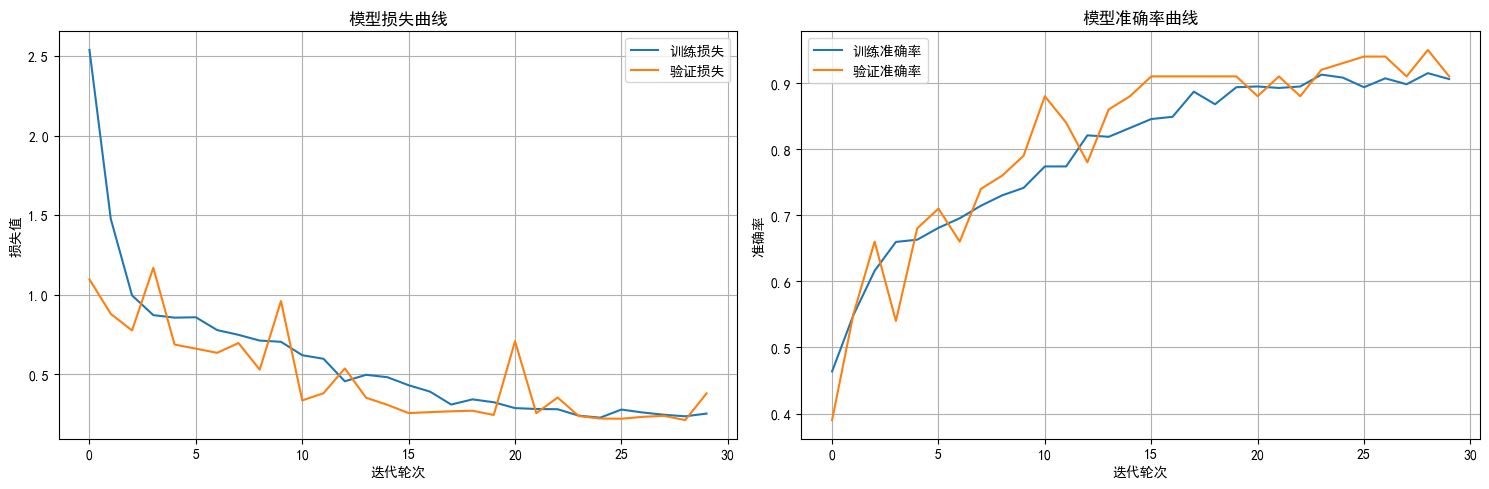

评估ResNet50...


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 10.27it/s, batch_loss=0.0791]


Test Loss: 0.2120 Acc: 0.9500

分类结果统计：
类别 bike: 样本数 29, 正确预测 28, 准确率 0.9655
类别 car: 样本数 32, 正确预测 30, 准确率 0.9375
类别 motorbike: 样本数 39, 正确预测 37, 准确率 0.9487

部分预测结果示例:
样本 1: 预测值=car, 真实值=car
样本 2: 预测值=car, 真实值=car
样本 3: 预测值=car, 真实值=car
样本 4: 预测值=bike, 真实值=bike
样本 5: 预测值=car, 真实值=car
样本 6: 预测值=car, 真实值=car
样本 7: 预测值=motorbike, 真实值=motorbike
样本 8: 预测值=motorbike, 真实值=motorbike
样本 9: 预测值=motorbike, 真实值=motorbike
样本 10: 预测值=bike, 真实值=bike


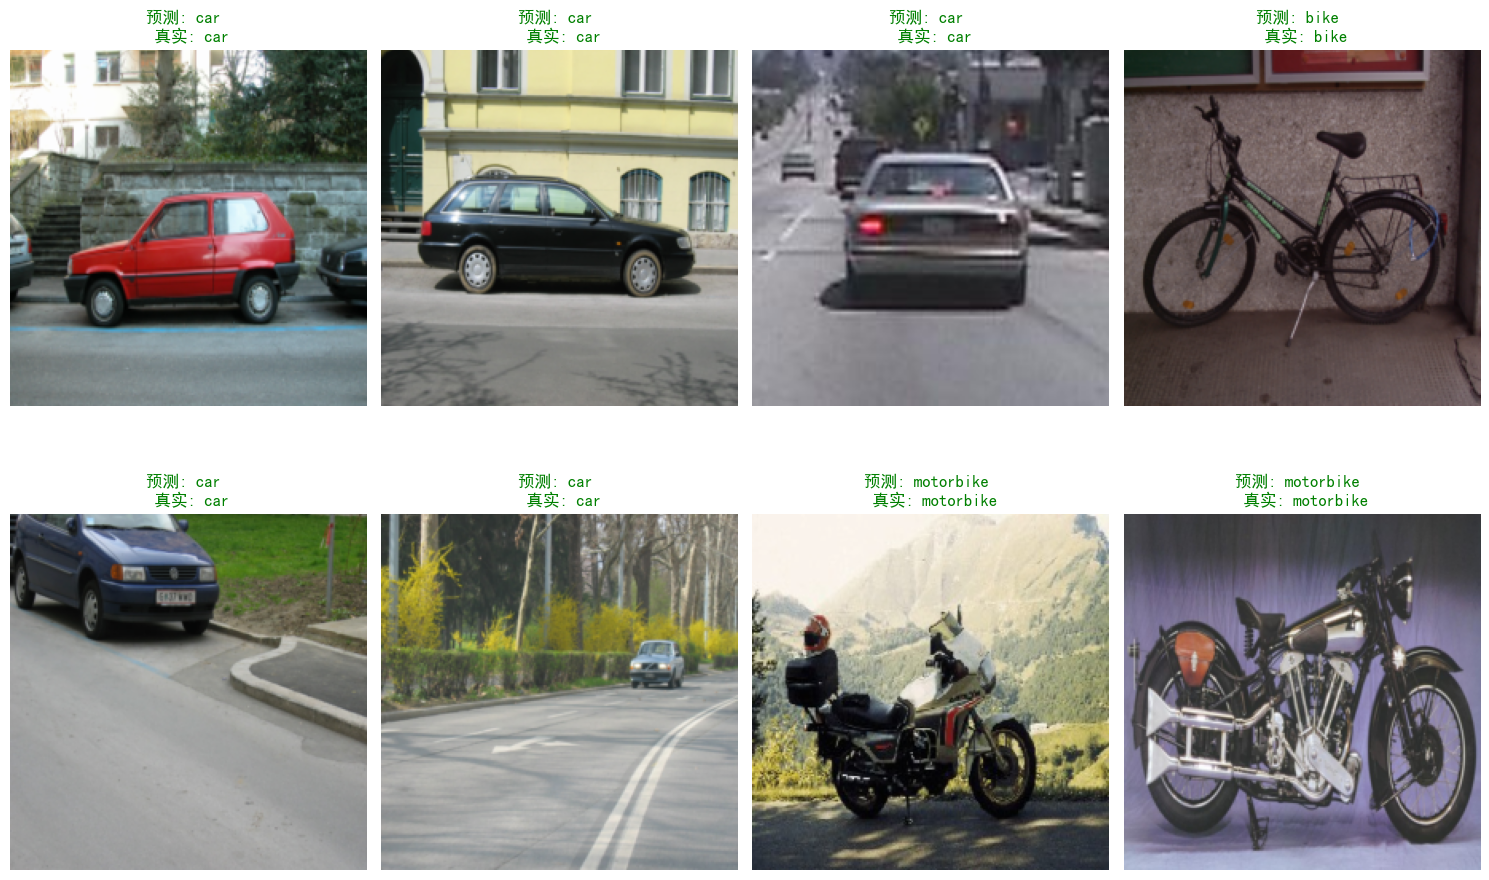

In [ ]:
os.makedirs(train_parameters["checkpoints"], exist_ok=True)

# 数据加载
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = VehicleDataset(r'C:\Coding\CVtest\test1\data1111', mode='train', transform=transform_train)
eval_dataset = VehicleDataset(r'C:\Coding\CVtest\test1\data1111', mode='eval', transform=transform_val)

# 适当减小批量大小，以减少显存使用
train_parameters['train_batch_size'] = 8  
train_loader = DataLoader(train_dataset, batch_size=train_parameters['train_batch_size'], shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=train_parameters['train_batch_size'], shuffle=False)

# 创建ResNet50模型，替代原来的ResNet101
model = ResNet50(num_classes=train_parameters['class_dim'])
print("模型结构: ResNet50")

# 计算模型参数量
total_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数量: {total_params:,}")

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 
                           lr=train_parameters['learning_rate'],
                           momentum=0.9)  # 添加权重衰减

# 训练模型
print("训练ResNet50...")
trained_model, history = train_model(model, train_loader, eval_loader, criterion, optimizer, 
                           train_parameters['device'], train_parameters['num_epochs'])

# 保存最终模型
torch.save(trained_model.state_dict(), os.path.join(train_parameters["checkpoints"], 'resnet50_final.pth'))

# 显示训练历史
plot_training_history(history)

# 评估模型
print("评估ResNet50...")
all_preds, all_labels = evaluate_model(model, eval_loader, criterion, train_parameters['device'])

# 可视化一些预测结果
visualize_predictions(model, eval_loader, train_parameters['device'])

# 三、模型评估

In [10]:
def evaluate_model(model, data_loader, criterion, device):
    """
    评估模型
    :param model: 模型
    :param data_loader: 数据加载器
    :param criterion: 损失函数
    :param device: 设备
    :return: 预测值和真实值列表
    """
    model.eval()  # 设置为评估模式
    running_loss = 0.0
    running_corrects = 0
    
    all_preds = []
    all_labels = []
    
    # 添加进度条
    eval_pbar = tqdm(data_loader, desc="Evaluating")
    
    with torch.no_grad():
        for inputs, labels in eval_pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            # 收集预测结果和真实标签
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # 更新进度条信息
            eval_pbar.set_postfix({"batch_loss": f"{loss.item():.4f}"})
    
    # 计算总损失和准确率
    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = running_corrects.double() / len(data_loader.dataset)
    
    print(f'Test Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
    # 确保all_preds和all_labels是列表或数组
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # 显示分类结果
    print("\n分类结果统计：")
    try:
        label_dict = train_parameters['label_dict']
        for i in range(len(label_dict)):
            label_name = label_dict[str(i)]
            label_count = np.sum(all_labels == i)
            correct_count = np.sum((all_preds == all_labels) & (all_labels == i))
            if label_count > 0:
                accuracy = correct_count / label_count
            else:
                accuracy = 0
            print(f"类别 {label_name}: 样本数 {label_count}, 正确预测 {correct_count}, 准确率 {accuracy:.4f}")
    
        # 打印部分预测结果示例
        print("\n部分预测结果示例:")
        for i in range(min(10, len(all_labels))):
            pred_label = label_dict[str(all_preds[i])]
            true_label = label_dict[str(all_labels[i])]
            print(f"样本 {i+1}: 预测值={pred_label}, 真实值={true_label}")
    except Exception as e:
        print(f"显示分类结果时出错: {str(e)}")
        print(f"预测标签范围: {np.min(all_preds)} - {np.max(all_preds)}")
        print(f"真实标签范围: {np.min(all_labels)} - {np.max(all_labels)}")
    
    return all_preds, all_labels

In [11]:
def visualize_predictions(model, data_loader, device, num_images=8):
    """
    可视化预测结果，支持中文显示
    :param model: 模型
    :param data_loader: 数据加载器
    :param device: 设备
    :param num_images: 可视化的图像数量
    :return: None
    """
    model.eval()
    
    # 设置中文字体支持
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
    
    # 获取标签字典
    label_dict = train_parameters['label_dict']
    
    # 获取一批数据
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    
    # 获取模型预测
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    # 将预测值和标签转移到CPU
    preds = preds.cpu().numpy()
    labels = labels.numpy()
    
    # 可视化
    fig, axes = plt.subplots(2, 4, figsize=(15, 10))
    axes = axes.flatten()
    
    for i in range(min(num_images, len(images))):
        # 把通道维度移到最后
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        # 反归一化
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        # 显示图像
        axes[i].imshow(img)
        
        # 设置标题 - 根据预测结果显示不同颜色
        if preds[i] == labels[i]:
            title_color = 'green'  # 预测正确显示绿色
        else:
            title_color = 'red'    # 预测错误显示红色
            
        axes[i].set_title(f'预测: {label_dict[str(preds[i])]} \n 真实: {label_dict[str(labels[i])]}', 
                 color=title_color, fontsize=12)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(train_parameters["checkpoints"], 'prediction_visualization.png'))
    plt.show()

In [ ]:
def predict(model, image_path, transform, device):
    """
    使用模型进行预测
    :param model: 模型
    :param image_path: 图像路径
    :param transform: 数据预处理
    :param device: 设备
    :return: 预测结果
    """
    model.eval()
    # 读取图像
    img = Image.open(image_path).convert('RGB')
    
    # 数据预处理
    img = transform(img).unsqueeze(0).to(device)
    
    # 预测
    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)
    
    return preds.item()
image_path = r'C:\Coding\CVtest\test1\pre_image\test3.jpg'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
model = ResNet50(num_classes=train_parameters['class_dim'])
model.load_state_dict(torch.load(os.path.join(train_parameters["checkpoints"], 'resnet50_final.pth')))
model = model.to(train_parameters['device'])
pred = predict(model, image_path, transform, train_parameters['device'])
label_dict = train_parameters['label_dict']
print(f"预测结果: {label_dict[str(pred)]}")


预测结果: car
